In [ ]:
import pandas as pd

df=pd.read_csv('merged_barrier_biasneu.csv')

#drop rows where column 'source' is human
df = df[df['source'] != 'human']

df = df[df['scenario'] != 'BIASED']

#drop columns bias_type, anchor_level
df = df.drop(columns=['bias_type', 'anchor_level'])

#change scenario from NEU to CONTEXT
df['scenario'] = df['scenario'].replace('NEU', 'CONTEXT')

#save to csv
df.to_csv('llm-barrier-context.csv', index=False)

print(df.info())
df.shape

In [14]:
#make 2 datasets into 1
import pandas as pd

barrier_zero  = "llm_barriers-zeroshot.csv"
barrier_context  = "llm-barrier-context.csv"
OUT_FILE = "merged_barriers_zero_context.csv"

# load
barrier_zero = pd.read_csv(barrier_zero)
barrier_context = pd.read_csv(barrier_context)

# keep exactly these shared columns (in this order)
cols = [
    'row_id','source','base_model','variant_id','model',
    'barrier_id','barrier_label','condition','iteration','timestamp'
]

# some columns may be missing in human (base_model/variant_id/model/iteration/timestamp) → create if needed
for c in cols:
    if c not in barrier_zero.columns: barrier_zero[c] = pd.NA
    if c not in barrier_context.columns: barrier_context[c] = pd.NA

merged = pd.concat([barrier_context[cols], barrier_zero[cols]], ignore_index=True)

# quick sanity (optional)
if 'barrier_id' in merged.columns:
    merged['barrier_id'] = pd.to_numeric(merged['barrier_id'], errors='coerce').astype('Int64')
    assert merged['barrier_id'].between(1,11).all(), "barrier_id outside 1..11"

merged.to_csv(OUT_FILE, index=False)
print("Saved:", OUT_FILE, "rows:", len(merged))

Saved: merged_barriers_zero_context.csv rows: 12000


In [2]:
import pandas as pd

df=pd.read_csv('merged_barriers_zero_context.csv')

#replace where condition is 'zeroshot'
df['condition'] = df['condition'].replace('NEU', 'CONTEXT')

#save to csv
df.to_csv('merged_barriers_zero_context.csv', index=False)

In [5]:
%pip install caas-jupyter-tools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement caas-jupyter-tools (from versions: none)
ERROR: No matching distribution found for caas-jupyter-tools


2025-09-03 11:10:46.299 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-03 11:10:46.707 
  command:

    streamlit run C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-03 11:10:46.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-03 11:10:46.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-03 11:10:47.029 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-09-03 11:10:47.069 Thread 'MainThread': missing ScriptRunContext! This warning can 

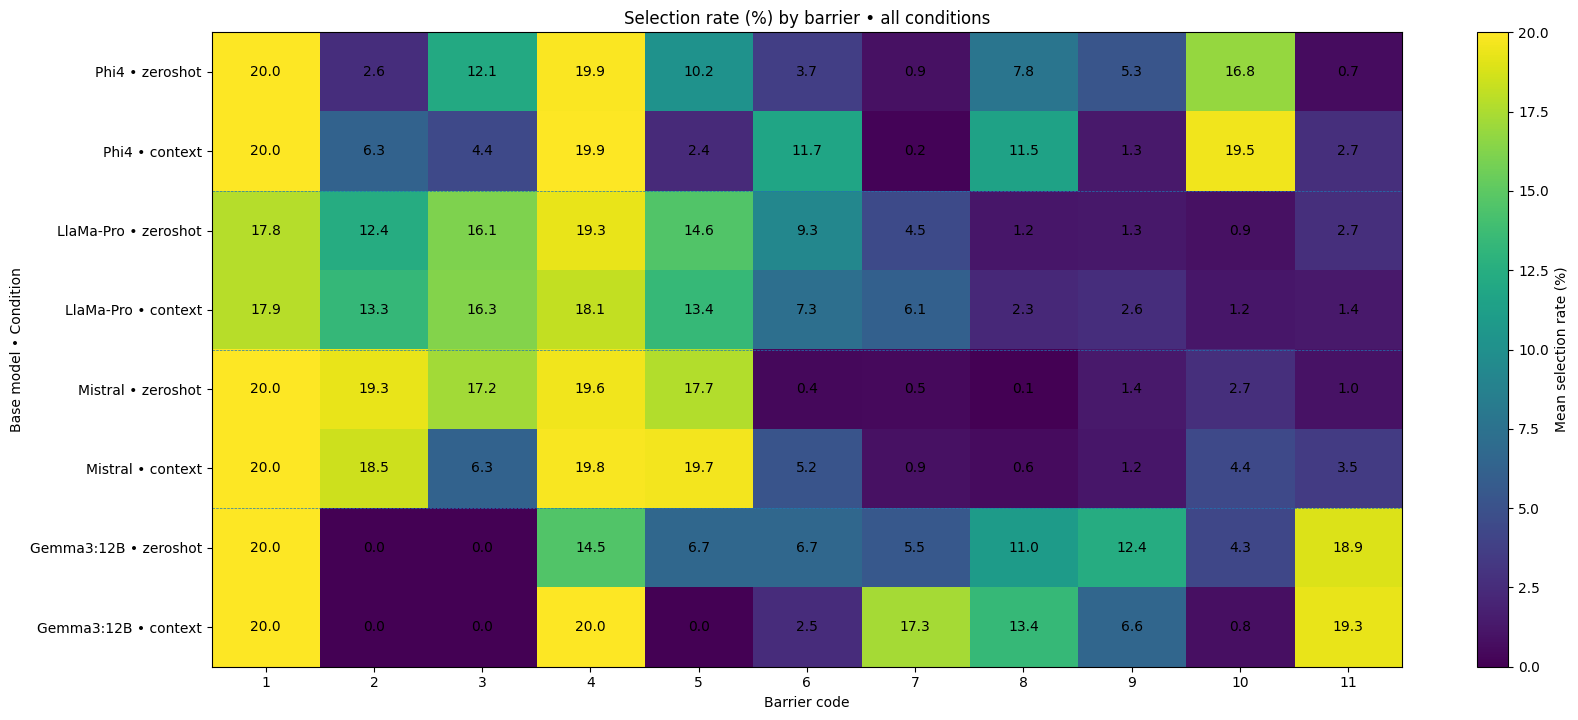

2025-09-03 11:10:49.123 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-03 11:10:49.149 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-03 11:10:49.150 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-03 11:10:49.151 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\streamlit\dataframe_util.py:821: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = pa.Table.from_pandas(df)
2025-09-03 11:10:49.158 Thread 'MainThread': missing

{'saved_plot': 'heatmap_all_conditions.png'}

<Figure size 640x480 with 0 Axes>

In [13]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import streamlit as st
#from caas_jupyter_tools import display_dataframe_to_user  = could not install required packages

# ----------------- OPTIONS (edit and re-run) -----------------
CMAP = "viridis"  # e.g., "viridis", "plasma", "magma", "cividis", "YlGnBu", "coolwarm", "Greys"
ANNOTATE = True   # print values inside cells
DECIMALS = 1      # annotation decimals
SEPARATOR = True  # draw thin horizontal separators between base families

FAMILY_RENAME = {"phi4":"Phi4", "llama":"LlaMa-Pro", "mistral":"Mistral", "gemma3":"Gemma3:12B"}
CONDITION_RENAME = {"ZEROSHOT":"Zeroshot", "NEU":"Neu", "BIASED":"Anchor", "INVERSE_ORDER":"Inverse Order", "INVERSE_ORDER":"Inverse Order", "INVERSE":"Inverse"}

FAMILY_ORDER = ["phi4","llama","mistral","gemma3"]
CONDITION_ORDER = ["zeroshot","neu","anchor","inverse order","inverse_order","inverse"]
# ---------------------------------------------------------------

# Load
csv_path = Path("merged_barriers_zero_context.csv")
df = pd.read_csv(csv_path)
df.columns = [c.strip().lower() for c in df.columns]
# ------------------------------------------------------------
# Normalize
df["condition"] = df["condition"].astype(str).str.lower().str.strip()
df["base_model"] = df["base_model"].astype(str).str.strip()
df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce")
df["barrier_id"] = pd.to_numeric(df["barrier_id"], errors="coerce").astype("Int64")

def to_family(x: str) -> str:
    x = str(x).lower()
    if x.startswith("llama"): return "llama"
    if x.startswith("phi4"): return "phi4"
    if x.startswith("mistral"): return "mistral"
    if x.startswith("gemma3"): return "gemma3"
    return x

df["base_family"] = df["base_model"].map(to_family)

barrier_ids = sorted([int(b) for b in df["barrier_id"].dropna().unique().tolist()])

avail_conditions = [c for c in CONDITION_ORDER if c in df["condition"].unique().tolist()] + \
                   [c for c in df["condition"].unique().tolist() if c not in CONDITION_ORDER]
avail_families = [f for f in FAMILY_ORDER if f in df["base_family"].unique().tolist()] + \
                 [f for f in df["base_family"].unique().tolist() if f not in FAMILY_ORDER]

# Build the small summary DF = replaced the display_dataframe_to_user
detected_df = pd.DataFrame({"base_family": avail_families}).assign(dummy='').merge(
    pd.DataFrame({"condition": avail_conditions}), how='cross'
).drop(columns='dummy')

# --- Show it (Streamlit or fallback) ---
try:
    import streamlit as st
    st.subheader("Detected families & conditions")
    st.dataframe(detected_df, use_container_width=True)
    st.download_button(
        "Download detected families/conditions (CSV)",
        detected_df.to_csv(index=False).encode("utf-8"),
        file_name="detected_families_conditions.csv",
        mime="text/csv",
    )
except Exception:
    # Jupyter/CLI fallback
    try:
        from IPython.display import display
        display(detected_df)
    except Exception:
        print(detected_df.to_string(index=False))


# Compute selection rates per iteration
counts = (df.groupby(["base_family","condition","iteration","barrier_id"])
            .size().rename("n_sel").reset_index())
totals = (df.groupby(["base_family","condition","iteration"])
            .size().rename("total_sel").reset_index())

triples = totals[["base_family","condition","iteration"]].drop_duplicates()
grid_full = triples.assign(key=1).merge(
    pd.DataFrame({"barrier_id": barrier_ids, "key":[1]*len(barrier_ids)}),
    on="key", how="outer").drop(columns=["key"])

rates = grid_full.merge(counts, on=["base_family","condition","iteration","barrier_id"], how="left").fillna({"n_sel":0})
rates = rates.merge(totals, on=["base_family","condition","iteration"], how="left")
rates["selection_rate"] = rates["n_sel"] / rates["total_sel"]

summ = (rates.groupby(["base_family","condition","barrier_id"])
              .agg(mean_rate=("selection_rate","mean"),
                   n_iter=("iteration","nunique"))
              .reset_index())
summ["pct"] = 100 * summ["mean_rate"]

families = [f for f in avail_families if f in summ["base_family"].unique()]
conditions = [c for c in avail_conditions if c in summ["condition"].unique()]

row_keys = [(f, c) for f in families for c in conditions]
pivot = (summ.pivot_table(index=["base_family","condition"], columns="barrier_id", values="pct")
              .reindex(row_keys).reindex(columns=barrier_ids))

row_labels = [f"{FAMILY_RENAME.get(f, f)} • {CONDITION_RENAME.get(c, c)}" for f,c in pivot.index]
col_labels = [str(b) for b in pivot.columns]

plt.figure(figsize=(1.2*len(col_labels)+4, 0.6*len(row_labels)+2.5))
plt.imshow(pivot.values, aspect="auto", cmap=CMAP)
plt.xticks(range(len(col_labels)), col_labels)
plt.yticks(range(len(row_labels)), row_labels)
plt.xlabel("Barrier code")
plt.ylabel("Base model • Condition")
plt.title("Selection rate (%) by barrier • all conditions")
cbar = plt.colorbar()
cbar.set_label("Mean selection rate (%)")

vals = pivot.values
if ANNOTATE:
    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            v = vals[i, j]
            if np.isfinite(v):
                plt.text(j, i, f"{v:.{DECIMALS}f}", ha="center", va="center")

if SEPARATOR and len(row_labels) > 1:
    fam_series = [idx[0] for idx in pivot.index]
    for i in range(1, len(fam_series)):
        if fam_series[i] != fam_series[i-1]:
            plt.hlines(i-0.5, xmin=-0.5, xmax=len(col_labels)-0.5, linestyles="dashed", linewidth=0.5)

plt.tight_layout()
out_path = "heatmap_all_conditions.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

matrix_df = pivot.reset_index().rename(columns={"base_family": "family", "condition": "condition"})

# --- Show it (Streamlit or fallback) ---
try:
    import streamlit as st
    st.subheader("Matrix for all-conditions heatmap (%)")
    st.dataframe(matrix_df, use_container_width=True)
    st.download_button(
        "Download heatmap matrix (CSV)",
        matrix_df.to_csv(index=False).encode("utf-8"),
        file_name="heatmap_matrix_all_conditions.csv",
        mime="text/csv",
    )
except Exception:
    try:
        from IPython.display import display
        display(matrix_df)
    except Exception:
        print(matrix_df.to_string(index=False))

# (optional) also save to disk regardless of UI
matrix_df.to_csv("heatmap_matrix_all_conditions.csv", index=False)

try:
    import streamlit as st
    st.pyplot(plt.gcf(), clear_figure=False)
    st.download_button(
        "Download heatmap PNG",
        data=open(out_path, "rb").read(),
        file_name=out_path,
        mime="image/png",
    )
except Exception:
    pass


{"saved_plot": out_path}

In [2]:
import pandas as pd
df=pd.read_csv('merged_barriers_zero_context.csv')
#count rows which have condition as 'context'
print(df[df['condition'] == 'CONTEXT'].shape[0])

6000
